In [1]:
%matplotlib inline

In [131]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm

from pandas.tools.plotting import scatter_matrix

### This lesson analyzes data from the following paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/pdf/839.pdf

#### How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use?

RNA-seq is now the technology of choice for genome-wide differential gene expression experiments, but it is not clear how many biological replicates are needed to ensure valid biological interpretation of the results or which statistical tools are best for analyzing the data. An RNA-seq experiment with 48 biological replicates in each of two conditions was performed to answer these questions and provide guidelines for experimental design. With three biological replicates, nine of the 11 tools evaluated found only 20%–40% of the significantly differentially expressed (SDE) genes identified with the full set of 42 clean replicates. This rises to >85% for the subset of SDE genes changing in expression by more than fourfold. To achieve >85% for all SDE genes regardless of fold change requires more than 20 biological replicates. The same nine tools successfully control their false discovery rate at ≲5% for all numbers of replicates, while the remaining two tools fail to control their FDR adequately, particularly for low numbers of replicates. For future RNA-seq experiments, these results suggest that at least six biological replicates should be used, rising to at least 12 when it is important to identify SDE genes for all fold changes. If fewer than 12 replicates are used, a superior combination of true positive and false positive performances makes edgeR and DESeq2 the leading tools. For higher replicate numbers, minimizing false positives is more important and DESeq marginally outperforms the other tools.

### Datafiles

There are 96 separate datafiles, each representing the processed output of an RNAseq experiment looking at mRNA levels in wild-type (48 samples) or SNF2 deletion (48 samples) yeast cells grown under standard condition. 

The files are incredible simple. Two columns, separated by tabs. The first column is the gene name, the second column the normalized counts for that gene in that sample (read the paper if you're interested in how they did the counting and normalization).

YBL013W 39
YBL014C 127
YBL015W 732
YBL016W 309
YBL017C 1613
YBL018C 174
YBL019W 117
YBL020W 258
YBL021C 248
YBL022C 1168
YBL023C 331
YBL024W 451
YBL025W 64
YBL026W 206
YBL027W 9723
YBL028C 77
YBL029C-A       157

Most of the genes have this naming format:

Systematic names for nuclear-encoded ORFs begin with the letter 'Y' (for 'Yeast'); the second letter denotes the chromosome number ('A' is chr I, 'B' is chr II, etc.); the third letter is either 'L' or 'R' for left or right chromosome arm; next is a three digit number indicating the order of the ORFs on that arm of a chromosome starting from the centromere, irrespective of strand; finally, there is an additional letter indicating the strand, either 'W' for Watson (the strand with 5' end at the left telomere) or 'C' for Crick (the complement strand, 5' end is at the right telomere).

You can read about the yeast gene naming system here - http://seq.yeastgenome.org/help/community/nomenclature-conventions. 

In [3]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [4]:
#
# the list frames is a list of dataframes 
# this is what they look like
#

frames[0].head()

,Gene,Snf2_rep14
0,15S_rRNA,212
1,21S_rRNA,762
2,HRA1,1
3,ICR1,207
4,LSR1,895


In [5]:
#
# Combines all of the individual frames into one dataframe, combining on the "Gene" column
# Column names are the data file
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [6]:
df.head()

,Gene,Snf2_rep14,WT_rep47,WT_rep03,WT_rep05,WT_rep02,WT_rep25,Snf2_rep16,Snf2_rep37,Snf2_rep33,...,WT_rep24,Snf2_rep47,Snf2_rep01,WT_rep44,Snf2_rep45,WT_rep09,WT_rep27,Snf2_rep41,WT_rep10,Snf2_rep29
0,15S_rRNA,212,12,31,21,12,11,5,8,16,...,5,6,4,12,34,7,9,6,6,6
1,21S_rRNA,762,107,101,128,76,63,38,30,76,...,46,44,31,58,234,57,54,67,104,60
2,HRA1,1,2,2,3,2,2,2,1,3,...,5,0,5,2,2,4,1,0,4,1
3,ICR1,207,187,107,98,123,139,175,145,239,...,116,195,205,81,148,119,133,184,132,216
4,LSR1,895,243,233,193,163,277,137,168,306,...,139,224,210,81,227,211,201,153,158,134


In [7]:
#
# Sort columns by name for convenience
#

df = df.reindex_axis(sorted(df.columns), axis=1)

In [8]:
df.head()

,Gene,Snf2_rep01,Snf2_rep02,Snf2_rep03,Snf2_rep04,Snf2_rep05,Snf2_rep06,Snf2_rep07,Snf2_rep08,Snf2_rep09,...,WT_rep39,WT_rep40,WT_rep41,WT_rep42,WT_rep43,WT_rep44,WT_rep45,WT_rep46,WT_rep47,WT_rep48
0,15S_rRNA,4,2,5,5,46,3,5,4,2,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,31,18,23,44,356,62,35,33,13,...,10,274,49,30,72,58,21,159,107,70
2,HRA1,5,1,3,1,2,1,1,4,4,...,5,3,6,5,2,2,2,5,2,1
3,ICR1,205,196,211,252,127,146,275,160,190,...,85,177,137,118,113,81,142,94,187,106
4,LSR1,210,103,159,260,298,522,303,96,132,...,66,385,232,149,114,81,109,132,243,128


In [9]:
#
# Use only genes starting with "Y" which are protein-coding genes
# You can come back and revisit this choice later if you want
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [10]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [11]:
# Save so we don't have to do all that again next time

df.to_csv("Barton_combined_Ygenes.txt", sep='\t')

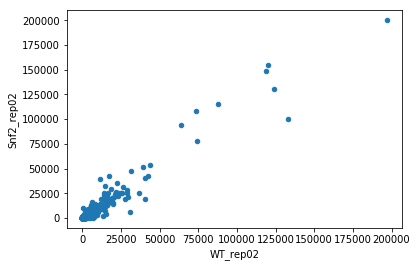

In [12]:
# Now let's look at some data

df.plot.scatter(x='WT_rep02',y='Snf2_rep02')

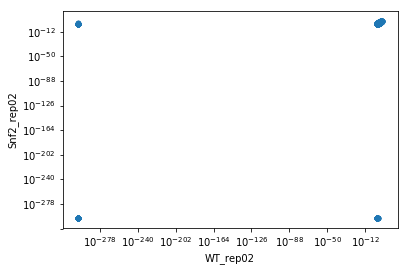

In [13]:
# most of the points are packed in a small range with only a few large values
# most common way to get around this is a log plot


df.plot.scatter(x='WT_rep02',y='Snf2_rep02',logx = True, logy= True)

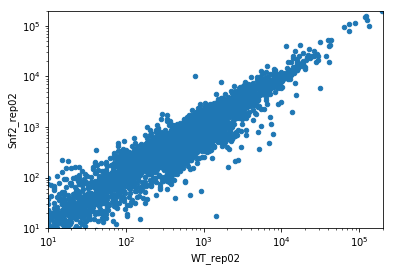

In [14]:
# well that didn't help - now there are values that are too small
# let's set lower and upper bounds for the plot

lower = 10
upper = max(df['WT_rep02'].max(),df['Snf2_rep02'].max())


df.plot.scatter(x='WT_rep02',y='Snf2_rep02',logx = True, logy= True, xlim=(lower,upper), ylim=(lower,upper))

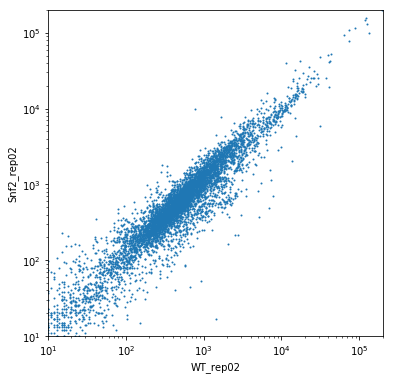

In [15]:
#
# do a few other things to make this pretty
# make points smaller with s=1
# set the figure size to be square
#

df.plot.scatter(x='WT_rep02',y='Snf2_rep02', s=1,logx = True, logy= True, xlim=(lower,upper), ylim=(lower,upper), figsize=(6,6))

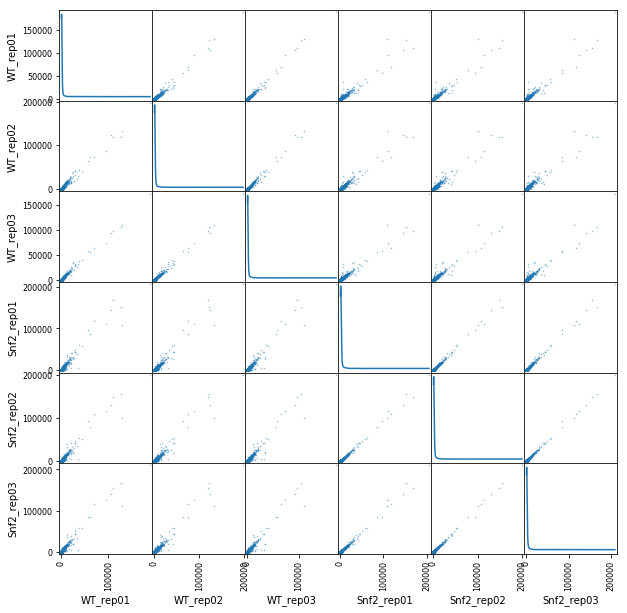

In [16]:
# 
# we'd love to do this for all pairs of columns
# let's start with a few
#

plot_columns = ['WT_rep01','WT_rep02','WT_rep03','Snf2_rep01','Snf2_rep02','Snf2_rep03']
sm = scatter_matrix(df[plot_columns],s=1,figsize=(10,10),diagonal='kde')

This quickly gets impossible to look at. So let's try something different. Instead of trying to look at every cell scatterplot, let's summarize each scatterplot with a number, say the correlation coefficient.

The paper discusses problems with individual samples. One way to screen for this in a sample that's so large is to look within the two sets for outliers.

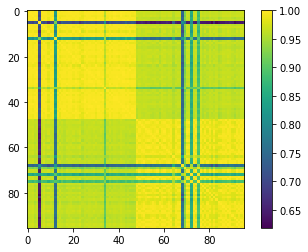

In [17]:
# get all columns

colnames = df.columns.get_values()

# create an empty matrix to store the correlations in

corrdata = np.zeros( (len(colnames),len(colnames)))

# loop through the columnames

for i1,c1 in enumerate(colnames):
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
im = plt.imshow(corrdata)
cb = plt.colorbar()

### Colormaps

This images are made by mapping a 2D array of values into colors by dividing values between the min and the max of array into bins and assigning each a color using a python colormap. You might not be a huge fan of this particular colormap. Well fear not! Python gives you lots of options. You can see them here https://matplotlib.org/tutorials/colors/colormaps.html.

In [18]:
print ("Last plot made with cmap", im.cmap.name)

Last plot made with cmap viridis


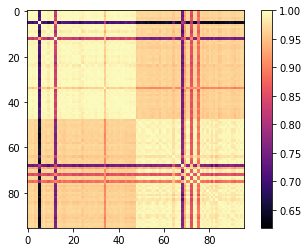

In [19]:
# let's try again with magma

im = plt.imshow(corrdata,cmap='magma')
cb = plt.colorbar()

### Removing outliers


Can see from plot about that there are several problematic samples that have correlations that are outliars. How should we filter them? Simplest way would be to pick an average correlation to other samples as a cutoff. What should we choose? 

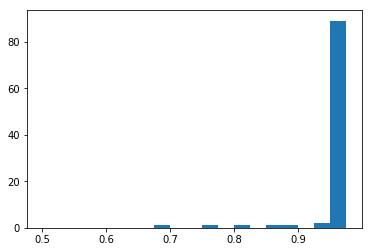

In [20]:
#
# Make a histogram of average correlation values
#

corrmeans = []
for i1,c1 in enumerate(corrdata):
    corrmeans.append(np.mean(c1))

hist = plt.hist(corrmeans, bins=np.arange(0.5,1.0,.025))

Most are above .95 so let's make that our cutoff

In [21]:
colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep06 0.691487784223
Removing  Snf2_rep13 0.803427905697
Removing  Snf2_rep35 0.932471392569
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  WT_rep25 0.86363576014
Removing  WT_rep28 0.891720439048


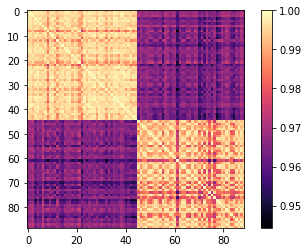

In [22]:
# now replot 

corrdata = np.zeros( (len(colnames),len(colnames)))

for i1,c1 in enumerate(colnames):
    d = []
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
plt.imshow(corrdata,cmap='magma')
plt.colorbar()

Still some heterogeneity but looks a lot better - no egregious outliars - so we'll use this set

### Question to think about: was this an ok thing to do?

When is/isn't it ok to remove data that looks wonky, and how should you do it?

Exercise 1: 

Let's imagine we did an experiment with no replicates - one sample per consdition. 

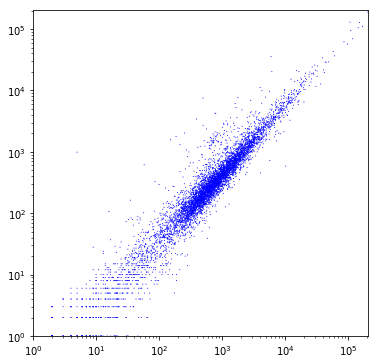

In [23]:
# let's pick a pair of WT and snf2 experiments and see how they compare

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)

ax.scatter(x, y, s = 1, c='b', edgecolor = 'none')


can already see a problem which is doesn't look like data fall along line x = y

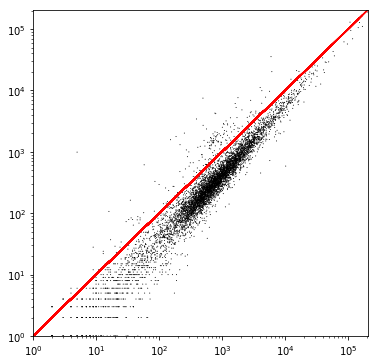

In [24]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Yikes!! Data should fall along line. We will return to this issue in a little bit but for now let's try another pair of samples.'

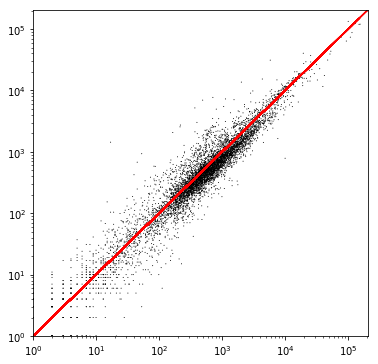

In [25]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Not perfect, but a lot better. So now, how do we identify outliers? Many people start by saying genes up or down 2x. So let's look at those.

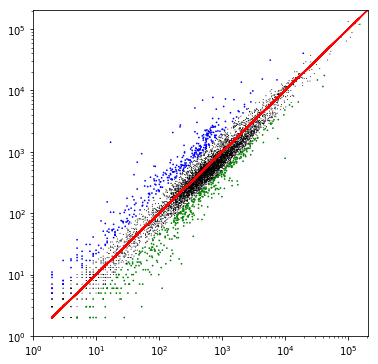

In [26]:
# pair to compare

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# select data, remove really low values

x = df[c1][(df[c1] > 1) & (df[c2] > 1)] # throw out really small values
y = df[c2][(df[c1] > 1) & (df[c2] > 1)]

# set color and size of points based on X/Y ratio

c = []
s = []

for i,vx in enumerate(x):    
    if x[i]/y[i] > 2.0:
        c.append('g')
        s.append(3)
    elif x[i]/y[i] < .5:
        c.append('b')
        s.append(3)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
ax.plot(x,x,'r-')

That's quite a lot of points! Should we believe them? Fortunately we can sanity check this because we actually have a lot more data. Let's start by comparing the Snf2/WT ratio in this pair of samples to a different pair. 

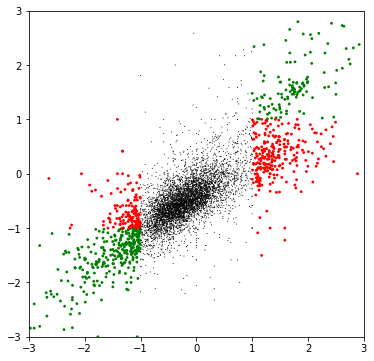

In [27]:
wt1 = 'WT_rep02'
wt2 = 'WT_rep03'
mut1 = 'Snf2_rep02'
mut2 = 'Snf2_rep03'

cols = [wt1,wt2,mut1,mut2]

# create a temporary data frame where any row with values < 1 are removed

tdf = df[cols][df > 1].dropna()

x = np.log2(tdf[wt1]/tdf[mut1])
y = np.log2(tdf[wt2]/tdf[mut2])

c = []
s = []

for i,vx in enumerate(x):    
    if x[i] > 1.0: 
        if y[i] > 1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    elif x[i] < -1.0:
        if y[i] < -1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
#ax.plot(x,x,'r-')

Clearly we need more than just one or two samples to accurately identify reproducible differences between samples. But how many do we need?

In [28]:
# now create lists for WT and Snf2 so we can start comparing them

colnames_snf2 = []
colnames_WT = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)

In [29]:
# create new columns that are averages

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)

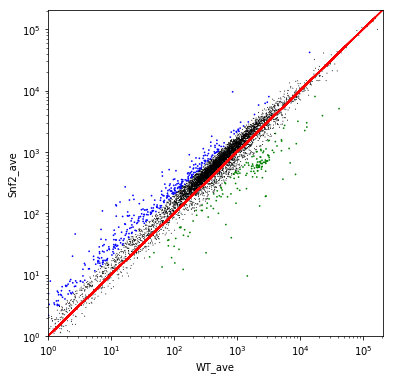

In [30]:
# pair to compare

c1 = 'WT_ave' 
c2 = 'Snf2_ave'

# select data, remove really low values

x = df[c1][(df[c1] > 1) & (df[c2] > 1)] # throw out really small values
y = df[c2][(df[c1] > 1) & (df[c2] > 1)]

# set color and size of points based on X/Y ratio

c = []
s = []

for i,vx in enumerate(x):    
    if x[i]/y[i] > 2.0:
        c.append('g')
        s.append(3)
    elif x[i]/y[i] < .5:
        c.append('b')
        s.append(3)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.set_xlabel(c1)
ax.set_ylabel(c2)
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
ax.plot(x,x,'r-')

### Looking at individual genes

Now we are going to start looking at individual genes. The first thing we're doing to do is sort based on the magnitude of the ratio between the WT and Snf2 averages and then plot the individual values.

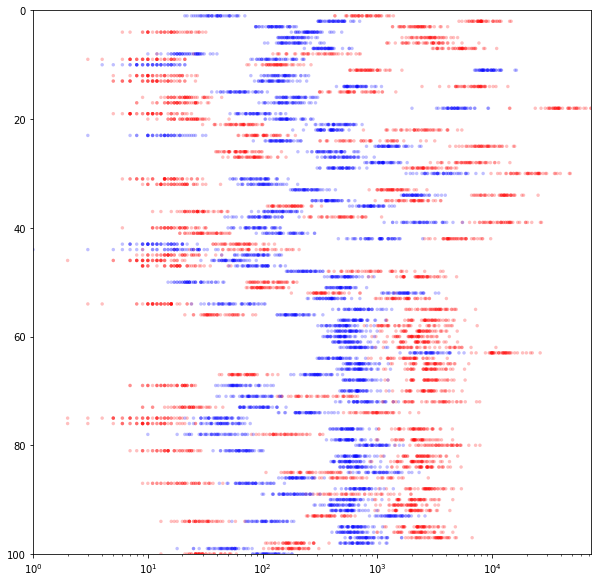

In [31]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['WT_ave','Snf2_ave']
tdf = df[cols][df > 10].dropna()

for index, row in tdf.iterrows():
    snf2 = row['Snf2_ave']
    wt = row['WT_ave']
    aved[index] = abs(np.log2(snf2/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds[0:100]):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(max(wt_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [32]:
# maybe median is a better value

df['Snf2_med'] = df[colnames_snf2].median(axis=1)
df['WT_med'] = df[colnames_WT].median(axis=1)
df['med'] = df[colnames_snf2 + colnames_WT].median(axis=1)

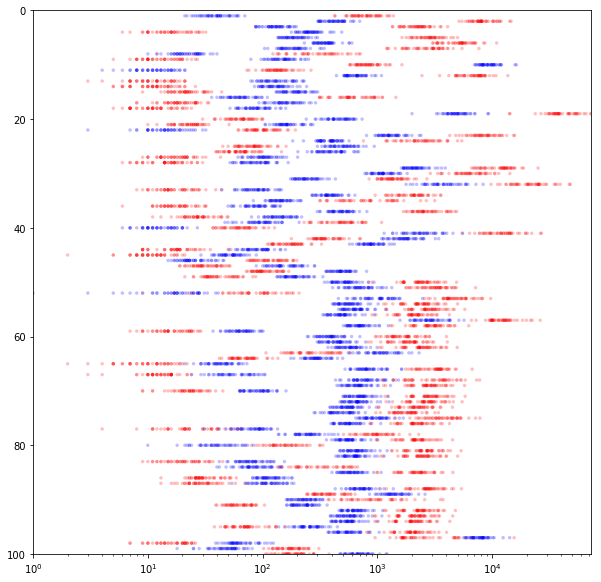

In [33]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['WT_med','Snf2_med']
tdf = df[cols][df > 10].dropna()

for index, row in tdf.iterrows():
    snf2 = row['Snf2_med']
    wt = row['WT_med']
    aved[index] = abs(np.log2(snf2/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds[0:100]):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(max(wt_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=12,alpha=.25,c='b',edgecolor='none')

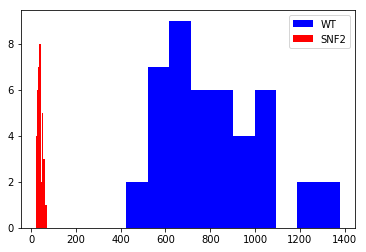

In [34]:
# lets look at individual genes a bit closer

gene = aveds[0]

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])
        
h = plt.hist(wt, color = 'blue',label='WT')
h = plt.hist(snf2, color = 'red',label='SNF2')
plt.legend()

In [35]:
print (aveds[0])

YHR136C


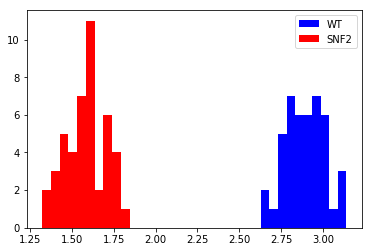

In [36]:
# log transform values

gene = aveds[0]

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(np.log10(df.at[gene,c]))
for c in colnames_WT:
    wt.append(np.log10(df.at[gene,c]))
        
h = plt.hist(wt,color = 'blue',label='WT')
h = plt.hist(snf2,color = 'red',label='SNF2')
plt.legend()

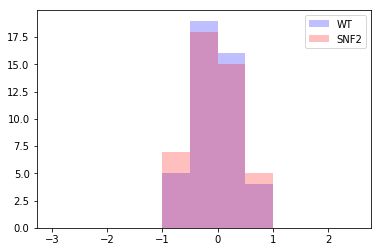

In [37]:
# log transform values

gene = aveds[0]

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(np.log2(df.at[gene,c]/df.at[gene,'Snf2_ave']))
for c in colnames_WT:
    wt.append(np.log2(df.at[gene,c]/df.at[gene,'WT_ave']))
        
h = plt.hist(wt, bins=np.arange(-3.00,3.00,0.5), color = 'blue',label='WT',alpha=0.25)
h = plt.hist(snf2,bins=np.arange(-3.00,3.00,0.5), color = 'red',label='SNF2',alpha=0.25)
plt.legend()

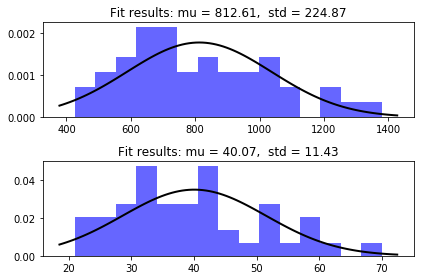

In [84]:
# do the data fit a normal distribution and do we have enough data to do a fit

gene = aveds[0]

snf2 = []
wt = []

for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])

# Fit a normal distribution to the data:
wt_mu, wt_std = norm.fit(wt)
snf2_mu, snf2_std = norm.fit(snf2)

ax = plt.subplot(2, 1, 1)
plt.hist(wt, bins=15, normed=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, wt_mu, wt_std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (wt_mu, wt_std)
plt.title(title)

ax = plt.subplot(2, 1, 2)
plt.hist(snf2, bins=15, normed=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, snf2_mu, snf2_std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (snf2_mu, snf2_std)
plt.title(title)

plt.tight_layout()
plt.show()

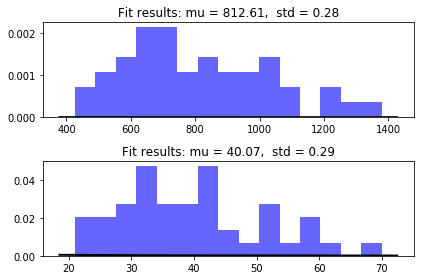

In [166]:
# do the data fit a normal distribution and do we have enough data to do a fit

gene = aveds[0]

snf2 = []
wt = []

for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])

# Fit a normal distribution to the data:
wt_std, loc, wt_mean = mu, loc, mean = lognorm.fit(wt, floc=0)
snf2_std, loc, snf2_mean = lognorm.fit(snf2, floc=0)

ax = plt.subplot(2, 1, 1)
plt.hist(wt, bins=15, normed=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, wt_mu, wt_std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (wt_mu, wt_std)
plt.title(title)

ax = plt.subplot(2, 1, 2)
plt.hist(snf2, bins=15, normed=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, snf2_mu, snf2_std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (snf2_mu, snf2_std)
plt.title(title)

plt.tight_layout()
plt.show()

### Now it's time to do some statistics

Probably better to treat this as a non-parametric test. The test most commonly used to ask if two distributions are different is the Kolmogorov-Smirnov test. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test


In [39]:
# do the data fit a normal distribution and do we have enough data to do a fit

gene = aveds[0]

snf2 = []
wt = []

for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])
    
print(ks_2samp(wt,snf2))

Ks_2sampResult(statistic=1.0, pvalue=6.097979597610006e-21)


In [43]:
# do the data fit a normal distribution and do we have enough data to do a fit

gene = aveds[0]

snf2 = []
wt = []

for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])
    
print(ks_2samp(wt,snf2))

Ks_2sampResult(statistic=1.0, pvalue=0.097026897595220707)


In [73]:
ksv = {}

for index, row in df.iterrows():
    snf2 = row[colnames_snf2]
    wt = row[colnames_WT]
    ksv[index] = -np.log10(ks_2samp(wt,snf2)[1])

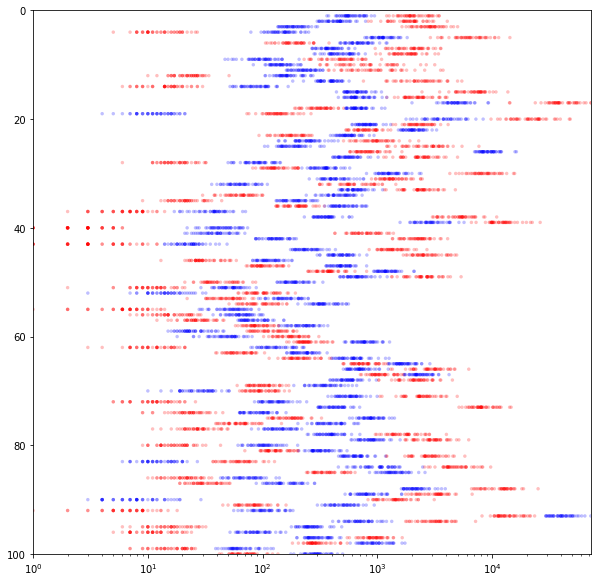

In [74]:
#ksv = {k:v for (k,v) in ksv.items() if v > 10.0}

ksvs = sorted(ksv.keys(),key = lambda x: ksv[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

for i,t in enumerate(ksvs[0:100]):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(max(wt_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [202]:
replicates = 100000
m1 = 1000
m2 = 500
v = .29

wt = np.random.lognormal(np.log(m1),v,replicates)
mut = np.random.lognormal(np.log(m2),v,replicates)

ks_2samp(wt,mut)

Ks_2sampResult(statistic=0.76810999999999996, pvalue=0.0)

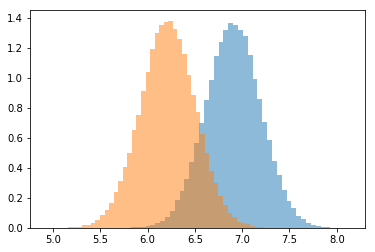

In [203]:
x = plt.hist(np.log(wt),bins=50,alpha=0.5,normed=True)
x = plt.hist(np.log(mut),bins=50,alpha=0.5,normed=True)

In [214]:

#
# lets look at the effect of changing the number of experiments we did
#

pvals = {}

trials = 100

sample_sizes = [5,10,15,20,25,30,35,40,45,50]
sample_sizes = [2,3,4,5,6,7,8,9,10,15,20]
for n in sample_sizes:
    pvals[n] = []
    for t in range(0,trials):
        wtr = np.random.choice(wt,n)
        mutr = np.random.choice(mut,n)
        pvals[n].append(-np.log10(ks_2samp(wtr,mutr)[1]))
    

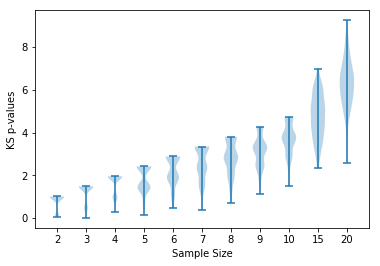

In [215]:
fig, axes = plt.subplots()

axes.violinplot(dataset = [pvals[v] for v in sample_sizes])
axes.set_title('')
axes.yaxis.grid(False)
axes.set_xlabel('Sample Size')
axes.set_ylabel('KS p-values')
a = plt.xticks(range(1,len(sample_sizes)+1),sample_sizes)